In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from fastai.vision.all import *
from fastai.vision import models 

import glob
print ('modules loaded')

modules loaded


In [3]:
from time import time

In [6]:

# Define the path to the dataset
dataset_path = 'images/dataset'

In [7]:


# Folders within the dataset
folders = ['dew', 'frost', 'hail', 'rain', 'rime', 'snow', 'fogsmog', 'glaze', 'lightning', 'rainbow', 'sandstorm']

# Initialize a dictionary to hold the number of images in each folder
image_count = {}

for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    images = os.listdir(folder_path)
    
    # Update image count
    image_count[folder] = len(images)

# Display the image count for each folder
for folder, count in image_count.items():
    print(f"{folder}: {count} images")


dew: 698 images
frost: 475 images
hail: 591 images
rain: 526 images
rime: 1160 images
snow: 621 images
fogsmog: 851 images
glaze: 639 images
lightning: 377 images
rainbow: 232 images
sandstorm: 692 images


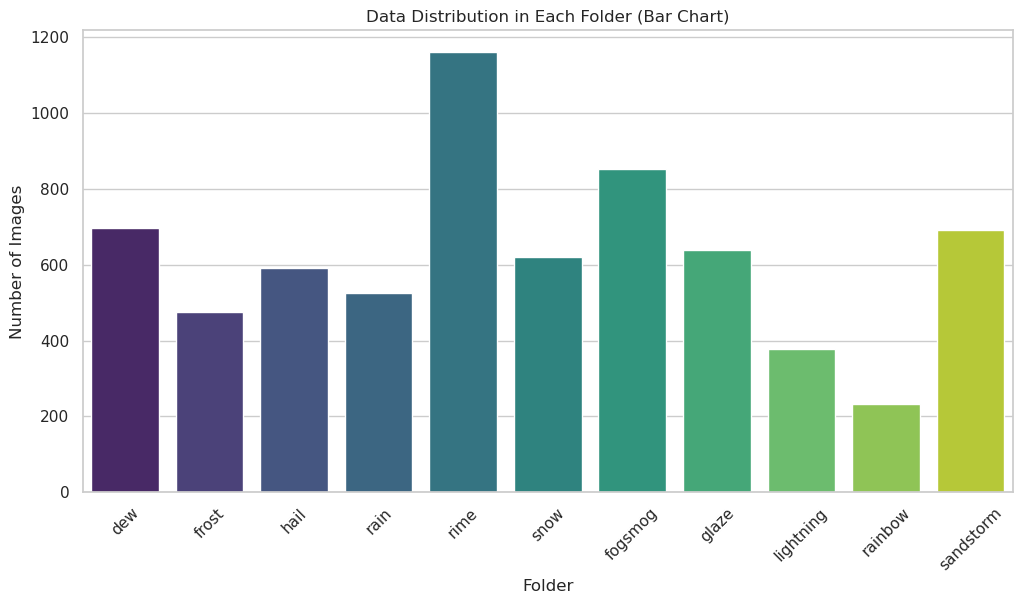

In [8]:
sns.set(style="whitegrid")

# Plotting the data distribution as a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=list(image_count.keys()), y=list(image_count.values()), palette="viridis")
plt.title('Data Distribution in Each Folder (Bar Chart)')
plt.xlabel('Folder')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


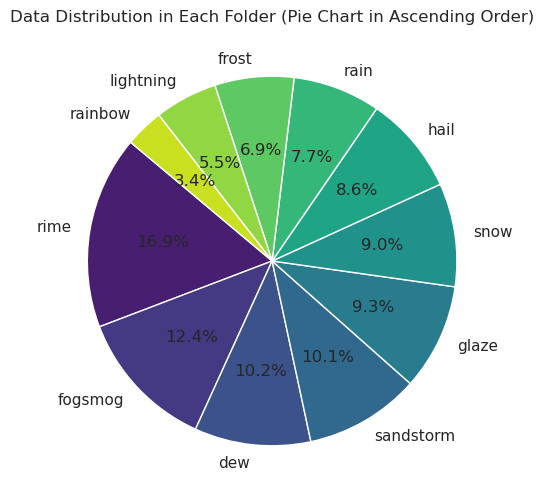

In [9]:
sorted_image_count = dict(sorted(image_count.items(), key=lambda item: item[1], reverse=True))

# Plotting the data distribution as a pie chart in ascending order
plt.figure(figsize=(12, 6))
plt.pie(sorted_image_count.values(), labels=sorted_image_count.keys(), autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(sorted_image_count)))
plt.title('Data Distribution in Each Folder (Pie Chart in Ascending Order)')
plt.show()


56.434248208999634


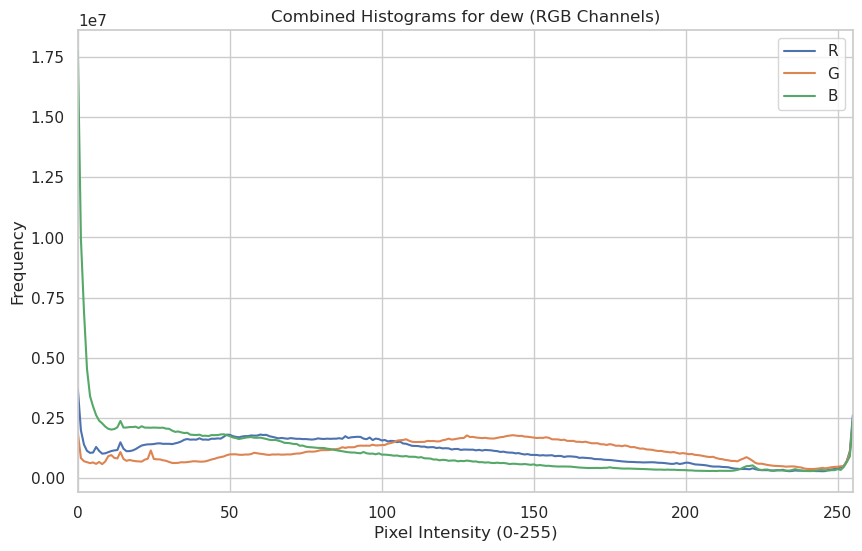

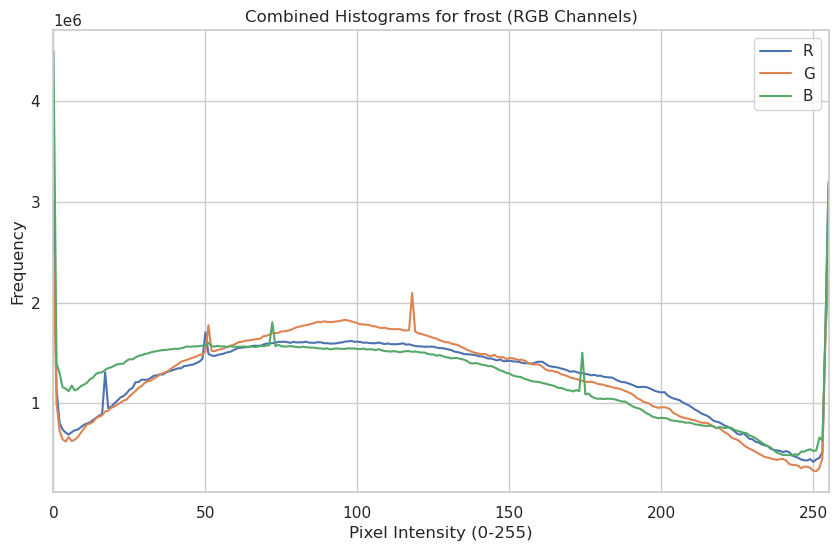

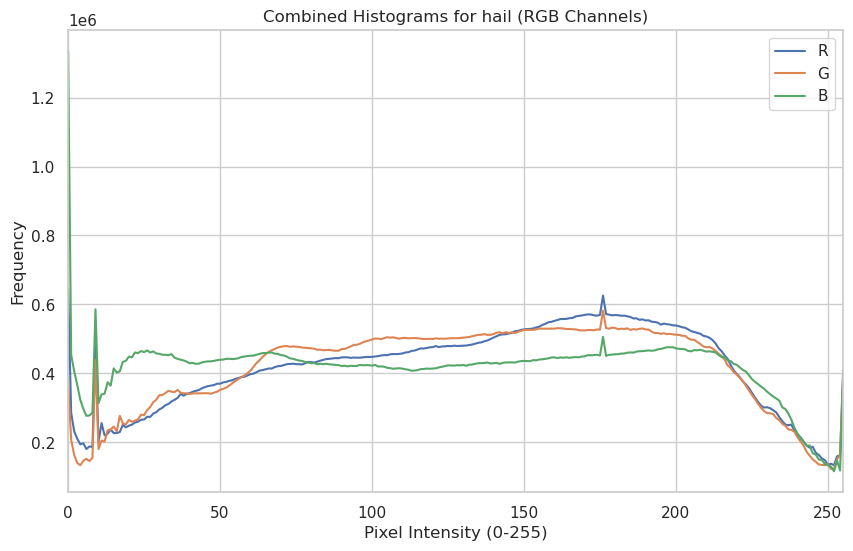

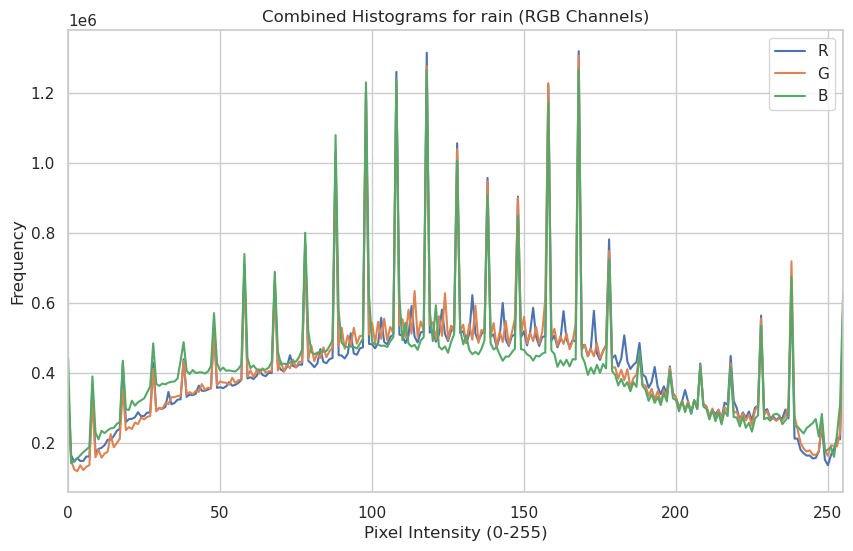

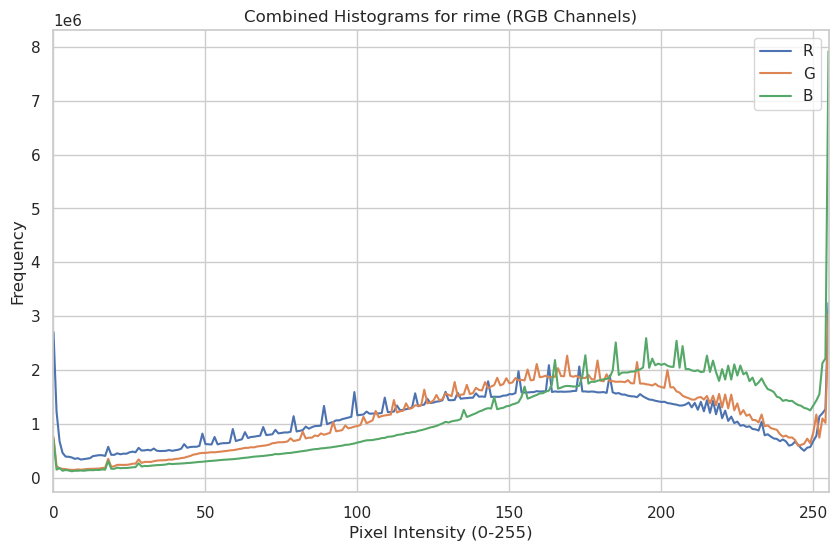

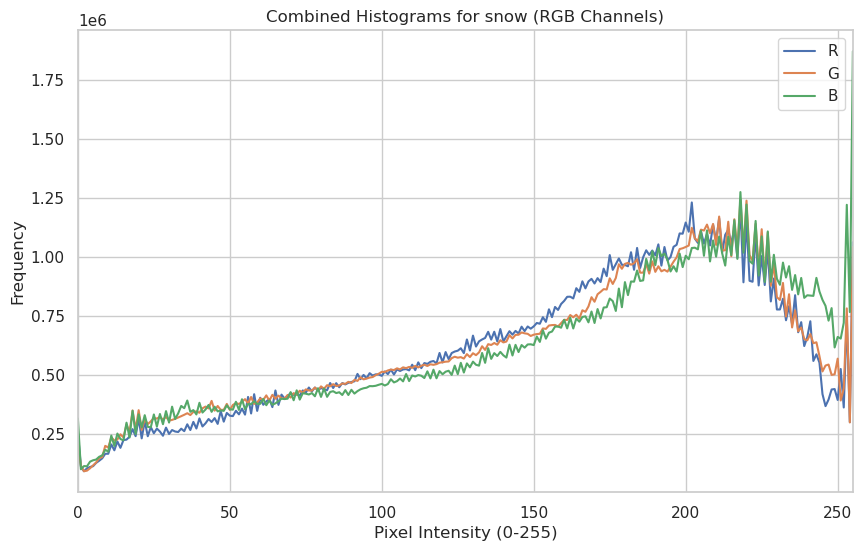

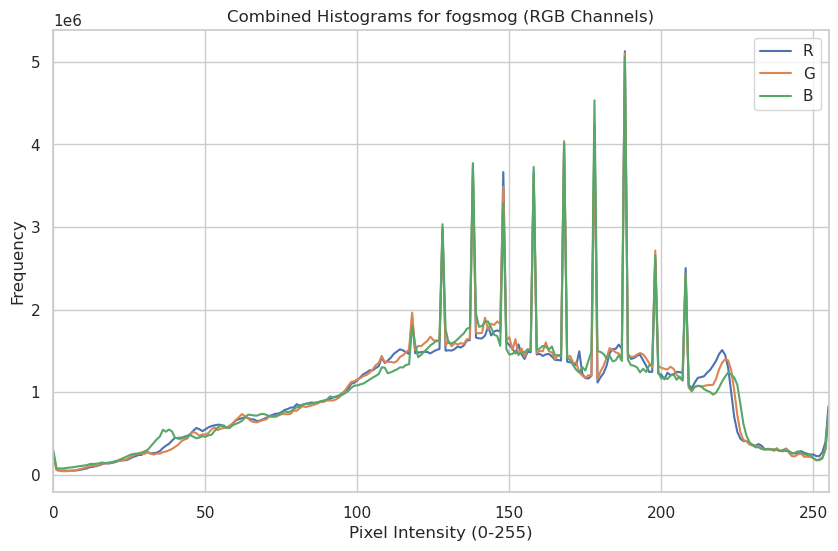

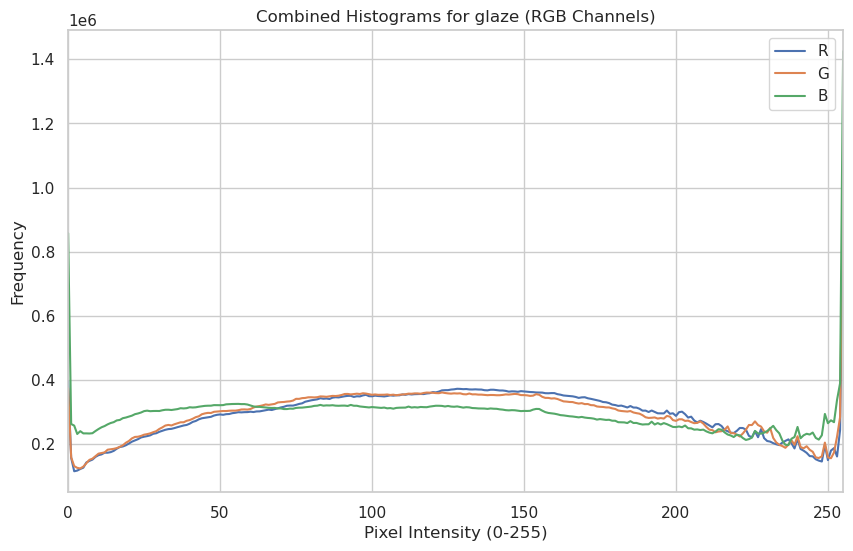

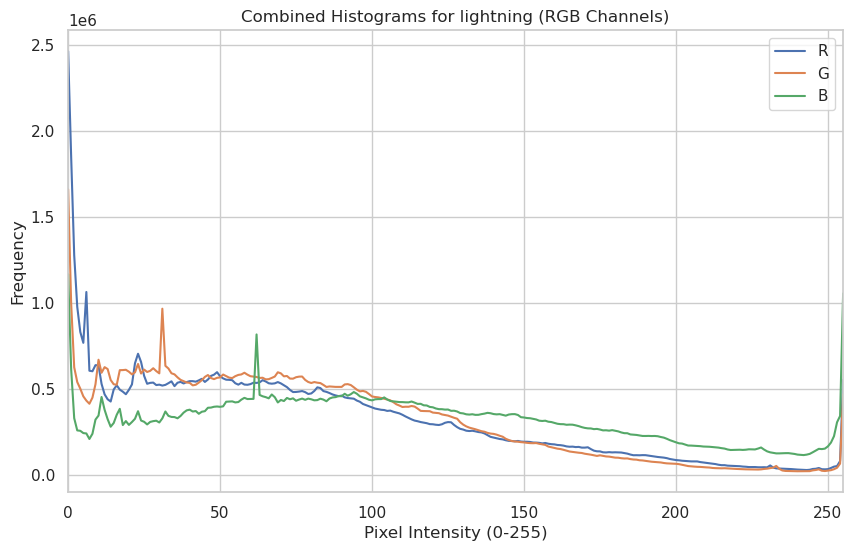

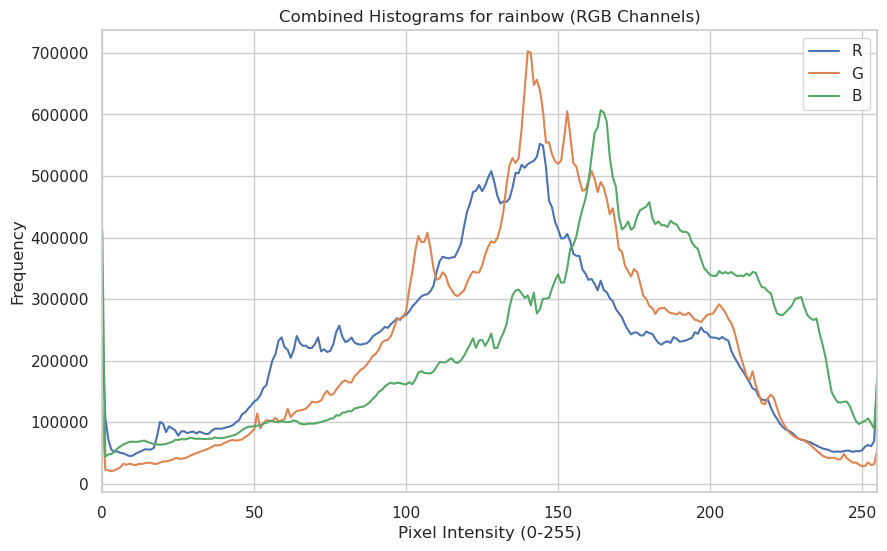

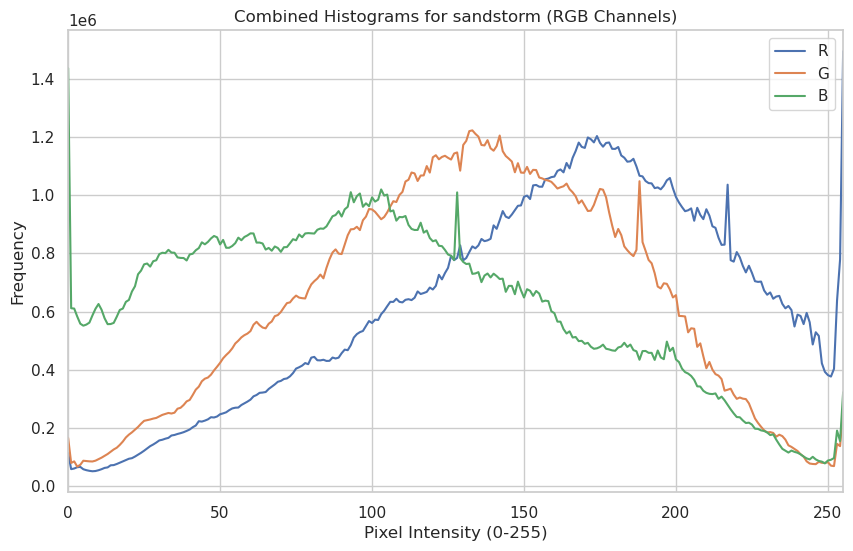

In [15]:
%timeit
start = time()

# Folders within the dataset
folders = ['dew', 'frost', 'hail', 'rain', 'rime', 'snow', 'fogsmog', 'glaze', 'lightning', 'rainbow', 'sandstorm']

# Initialize a dictionary to hold the combined histograms for each channel
histograms = {folder: {'R': [], 'G': [], 'B': []} for folder in folders}

# Process each folder
for folder in (folders):
    folder_path = os.path.join(dataset_path, folder)
    images = os.listdir(folder_path)
    
    # Process each image
    for image_name in images:
        image_path = os.path.join(folder_path, image_name)
        with Image.open(image_path) as img:
            # Convert image to RGB if not already
            img_rgb = img.convert('RGB')

            # Calculate histogram for each color channel
            for channel, color in zip(range(3), ['R', 'G', 'B']):
                hist = img_rgb.getchannel(channel).histogram()
                histograms[folder][color].append(hist)

# Combine histograms for each color channel in each folder
for folder in histograms.keys():
    for color in ['R', 'G', 'B']:
        histograms[folder][color] = [sum(x) for x in zip(*histograms[folder][color])]

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

end = time()
print(end - start)
# Plotting histograms with seaborn style
for folder in folders:
    plt.figure(figsize=(10, 6))
    
    for color in ['R', 'G', 'B']:
        sns.lineplot(data=histograms[folder][color], label=color)

    plt.title(f'Combined Histograms for {folder} (RGB Channels)')
    plt.xlabel('Pixel Intensity (0-255)')
    plt.ylabel('Frequency')
    plt.xlim([0, 255])
    plt.legend()
    plt.show()

In [16]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
import numpy as np
from time import time

# Function to process each folder
def process_folder(folder):
    folder_path = os.path.join(dataset_path, folder)
    images = os.listdir(folder_path)
    folder_histograms = {'R': [], 'G': [], 'B': []}

    for image_name in images:
        image_path = os.path.join(folder_path, image_name)
        with Image.open(image_path) as img:
            img_rgb = img.convert('RGB')
            for channel, color in zip(range(3), ['R', 'G', 'B']):
                hist = img_rgb.getchannel(channel).histogram()
                folder_histograms[color].append(hist)

    # Combine histograms for each color channel
    for color in ['R', 'G', 'B']:
        folder_histograms[color] = np.sum(folder_histograms[color], axis=0).tolist()

    return folder, folder_histograms


# Folders within the dataset
folders = ['dew', 'frost', 'hail', 'rain', 'rime', 'snow', 'fogsmog', 'glaze', 'lightning', 'rainbow', 'sandstorm']

cpu_counts = [1, 2, 4, 8,16]  # Number of CPUs to test

for cpu_count in cpu_counts:
    start = time()

    # Using multiprocessing Pool with different number of processes
    with Pool(processes=cpu_count) as pool:
        results = pool.map(process_folder, folders)

    # Reconstructing histograms dictionary from results
    histograms = {folder: data for folder, data in results}

    end = time()
    print(f"Execution Time with {cpu_count} CPU(s): {end - start} seconds")


Execution Time with 1 CPU(s): 47.723897218704224 seconds
Execution Time with 2 CPU(s): 25.327226638793945 seconds
Execution Time with 4 CPU(s): 18.72960138320923 seconds
Execution Time with 8 CPU(s): 17.873056650161743 seconds
Execution Time with 16 CPU(s): 18.372941732406616 seconds


In [17]:
import os
from PIL import Image
import numpy as np
import dask
from dask import delayed, compute
import dask.array as da

# Function to process each folder
@delayed
def process_folder(folder):
    folder_path = os.path.join(dataset_path, folder)
    images = os.listdir(folder_path)
    folder_histograms = {'R': [], 'G': [], 'B': []}

    for image_name in images:
        image_path = os.path.join(folder_path, image_name)
        with Image.open(image_path) as img:
            img_rgb = img.convert('RGB')
            for channel, color in zip(range(3), ['R', 'G', 'B']):
                hist = img_rgb.getchannel(channel).histogram()
                folder_histograms[color].append(hist)

    # Combine histograms for each color channel
    for color in ['R', 'G', 'B']:
        folder_histograms[color] = np.sum(folder_histograms[color], axis=0).tolist()

    return folder, folder_histograms
start= time()

# Folders within the dataset
folders = ['dew', 'frost', 'hail', 'rain', 'rime', 'snow', 'fogsmog', 'glaze', 'lightning', 'rainbow', 'sandstorm']

# Create a list of delayed tasks
tasks = [process_folder(folder) for folder in folders]

# Compute all tasks in parallel
folder_histograms_results = compute(*tasks)

# Convert the results to a dictionary
histograms = {folder: data for folder, data in folder_histograms_results}

# Now histograms dictionary contains the combined histograms for each folder
end = time()
print(end-start)

20.196638584136963
